# Методы сжатия и обработки видео

Полезные ссылки:
* [Telegram-канал](https://t.me/vgcourse)
* [Документация pybind](https://pybind11.readthedocs.io/en/stable/)

Понадобится для работы:
* Pybind11: `conda install -c conda-forge pybind11` (если у вас [Anaconda](www.anaconda.com) или `pip install pybind11`)
* Opencv2: `conda install -c conda-forge opencv` или `pip install opencv-python`) 
* C++ компилятор  

*Если у вас не заработало что-то, смело пишите в чатик курса*

## Задание 3. Motion Estimation ##

Шаблон для выполнения задания состоит из нескольких частей

1. Библиотека ME на C/C++, компилируемая для использования в python-коде. В основном писать код вам придётся именно в библиотеке. Чтобы скомпилировать библиотеку, запустите команду `python3 setup.py build_ext -i` в  корне папки с заданием. *Замечание. Это библиотека компилируется под C++, но внутри вам ничего не мешает писать код на чистом C.*
2. Ipython notebook для тестирования библиотеки. Используйте этот код для оценки качества работы программы и её улучшения.

### 1. Основная часть ###

Оценка качества работы алгоритма будет производиться следующим образом: на основе поля ME между двумя кадрами будет построен восстановленный кадр. Для оценивания качества будет использоваться PSNR между восстановленным и исходным кадром:

<img src="images/me_example.png">

<img src="images/how_it_works.png">

Кроме того, ещё одним параметром работы будет являться **скорость работы**.

In [1]:
# Импортируем нужные библиотеки
import cv2
import time
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import random
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import matplotlib as mpl 
mpl.rcParams['animation.ffmpeg_path'] = r'C:\\ffmpeg\\bin\\ffmpeg.exe'
import matplotlib.gridspec as gridspec


In [2]:
#Библиотека для чтения видео
class VideoReader:
    def __init__(self, path):
        self.cap = cv2.VideoCapture(path)
        self.height = int(self.cap.get(4))
        self.width = int(self.cap.get(3))
    
    def __iter__(self):
        while(self.cap.isOpened()):
            ret, frame = self.cap.read()
            if ret == False:
                break
            yield frame
    
    def height(self):
        return self.heigth
    
    def width(self):
        return self.width
    
    def __del__(self):
        self.cap.release()

def generate_pair_frames_gray(video):
    prev_frame = None
    for frame in video:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        if prev_frame is None:
            prev_frame = frame
        else:
            yield prev_frame, frame
            prev_frame = frame

In [3]:
def show_pair_frames(compensated_frame, frame, psnr_value):
    fig = plt.figure(figsize=(16,7))
    plt.suptitle('Значение PSNR: {:.4f}'.format(psnr_value), fontsize=24)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(compensated_frame, cmap='gray')
    ax.set_title("Скомпенсированный кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(frame, cmap='gray')
    ax.set_title("Текущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])

In [4]:
def visualize_motion_vectors(img, ofs, block_size=16):
    plt.clf()
    ax = plt.gca()
    ver, hor = ofs[0], ofs[1]
    ver = cv2.resize(ver, (ver.shape[1] // block_size, ver.shape[0] // block_size))
    hor = cv2.resize(hor, (hor.shape[1] // block_size, hor.shape[0] // block_size))

    height, width = ver.shape

    xx, yy = np.meshgrid(np.arange(width), np.arange(height))

    xx = block_size * (xx + 0.5)
    yy = block_size * (yy + 0.5)
    
    ax.set_title('Some title')
    ax.imshow(img, cmap='gray', alpha=0.5)
    ax.quiver(xx, yy, hor, ver, angles='xy', scale_units='xy', scale=1)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [5]:
def calc_psnr_for_blocks(frame1, frame2, block_size):
    out = np.zeros((frame1.shape[0] // block_size, frame1.shape[1] // block_size))
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            x = i * block_size
            y = j * block_size
            out[i][j] = peak_signal_noise_ratio(
                frame1[x: x + block_size, y : y + block_size], \
                frame2[x: x + block_size, y : y + block_size]
            )
    return out
            
def psnr_for_blocks(i, block_size):
    return calc_psnr_for_blocks(result["compensated_frames"][i], result['source_frames'][i], block_size)

In [6]:
def mse(A, B):
    return ((A - B)**2).mean()

def calc_mse_for_blocks(frame1, frame2, block_size):
    out = np.zeros((frame1.shape[0] // block_size, frame1.shape[1] // block_size))
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            x = i * block_size
            y = j * block_size
            out[i][j] = mse(
                frame1[x: x + block_size, y : y + block_size], \
                frame2[x: x + block_size, y : y + block_size]
            )
    return out
            
def mse_for_blocks(i, block_size):
    return calc_mse_for_blocks(result["compensated_frames"][i], result['source_frames'][i], block_size)

In [7]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Простая функция для тестирования ME.
def test_me(source_video, me, return_frames=False, result_path=None, return_ofs=False):
    ssim = []
    psnr = []
    speed = []
    compensated_frames = []
    source_frames = []
    ofs = []
    out_video = None
    if result_path is not None:
        out_video = cv2.VideoWriter(
            result_path,
            cv2.VideoWriter_fourcc(*'mp4v'),
            10,
            (source_video.width, source_video.height * 2)
        )
     
    pbar = tqdm(generate_pair_frames_gray(source_video))
    for frame, prev_frame in pbar:
        start = time.time()
        result = me.Estimate(frame, prev_frame) # Запускаем me
        end = time.time()
        speed.append((end - start) * 1000)
        compensated_frame = result.Remap(prev_frame) # Скомпенсированный кадр лежит тут. Полезно для дебага его отсюда доставать и рассматривать.
        
        ssim.append(structural_similarity(frame, compensated_frame, multichannel=False))
        psnr.append(peak_signal_noise_ratio(frame, compensated_frame))
        if return_frames:
            compensated_frames.append(compensated_frame)
            source_frames.append(frame)
        if return_ofs:
            ofs.append(result.ConvertToOF())
        
        
        pbar.set_description('PSNR: {:.2f}; Time(ms): {:.2f}; SSIM: {:.2f}.'.format(np.mean(psnr), np.mean(speed), np.mean(ssim)))
        
        if out_video is not None:
            out_video.write(cv2.cvtColor(np.vstack([frame, compensated_frame]), cv2.COLOR_GRAY2BGR))
    if out_video is not None:
        out_video.release()
        
    return {
        'ssim': ssim,
        'psnr': psnr,
        'speed': speed,
        'compensated_frames': compensated_frames,
        'source_frames': source_frames,
        'ofs': ofs
    }

## Ваше решение

- В качестве решения вы должны прикрепить класс ниже.
- Менять прототипы для init и Estimate **нельзя**.
- **Должен** быть возможен вызов вида `test_me(video, me)`.

In [8]:
# GRADED CELL: MotionEstimator

class MotionEstimator:
    def __init__(self, width, height, quality, halfpixel):
        import me_estimator
        
        self.width = width
        self.height = height
        self.quality = quality
        self.halfpixel = halfpixel

        # На данный момент в me_estimator реализован полный перебор - смотреть MotionEstimator::CEstimate
        self.me = me_estimator.MotionEstimator(self.width, self.height, self.quality, self.halfpixel)

    def Estimate(self, frame, prev_frame):
        return self.me.Estimate(frame, prev_frame)

**Если вы делали какие-то изменения, то не забудьте перезагрузить модуль. Для этого нажмите Kernel->Restart**

Чтобы проверить, как работет библиотека, давайте проверим его на одной последовательности на самом хорошем качестве.  
*То, что Ваше ME будет по качеству работать хуже полного перебора - это норма. Ваша задача - достаточно сильно ускорить ME, он должен работать ориентировочно за 5-10 мс на кадр. Ориентировочная точка - одно из самых лучших решений прошлого года на среднем ноутбуке показало **5.06ms и 35.1 psnr** на качестве 100.*

In [9]:
video = VideoReader('video/source.avi')
me = MotionEstimator(video.width, video.height, 100, False)
result = test_me(video, me, True, 'result.mp4', True) # В result.mp4 сохраняем скомпенсированное видео, также в result будут лежать кадры

0it [00:00, ?it/s]

Посмотрим на то, как компенсируется произвольный кадр:

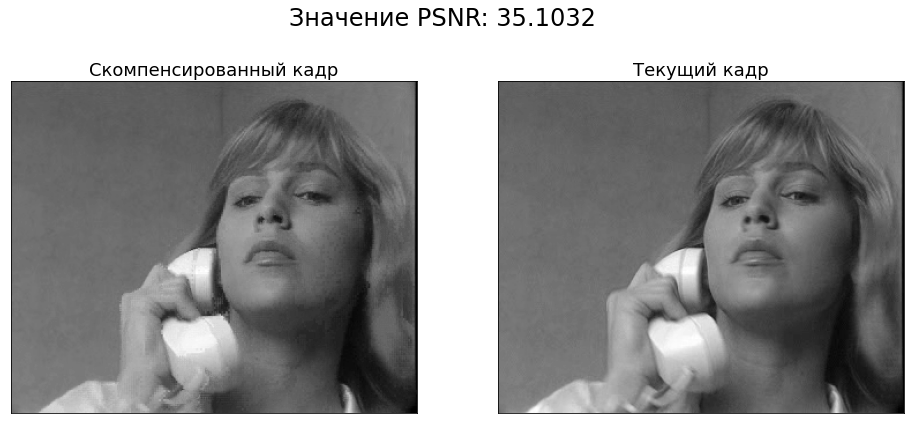

In [10]:
frame_idx = 25
show_pair_frames(
    result['compensated_frames'][frame_idx],
    result['source_frames'][frame_idx],
    result['psnr'][frame_idx]
)

Посмотрим на найденные вектора движения

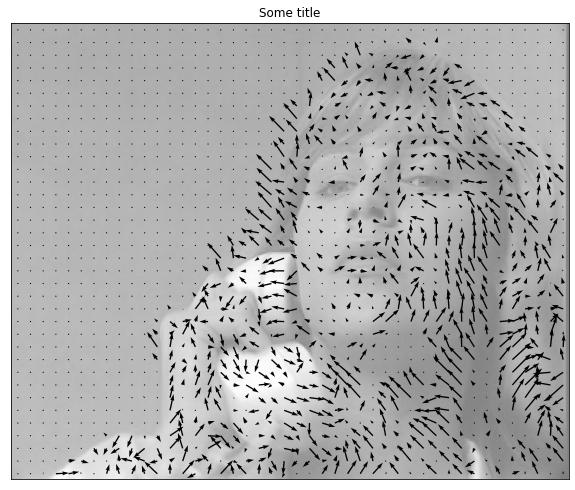

In [11]:
frame_idx = 25
plt.figure(figsize=(10, 10))
ax = visualize_motion_vectors(
    result['source_frames'][frame_idx],
    result['ofs'][frame_idx],
    block_size = 8
)
plt.show()

In [96]:
def calc_disp(hor):
    return ((hor - hor.mean()) ** 2).sum()

In [102]:
print(np.array(result['source_frames'][0].shape) / 2)

[144. 176.]


Сделаем анимацию

<ipython-input-96-406b23fa09e7>:2: RuntimeWarning: Mean of empty slice.
  return ((hor - hor.mean()) ** 2).sum()


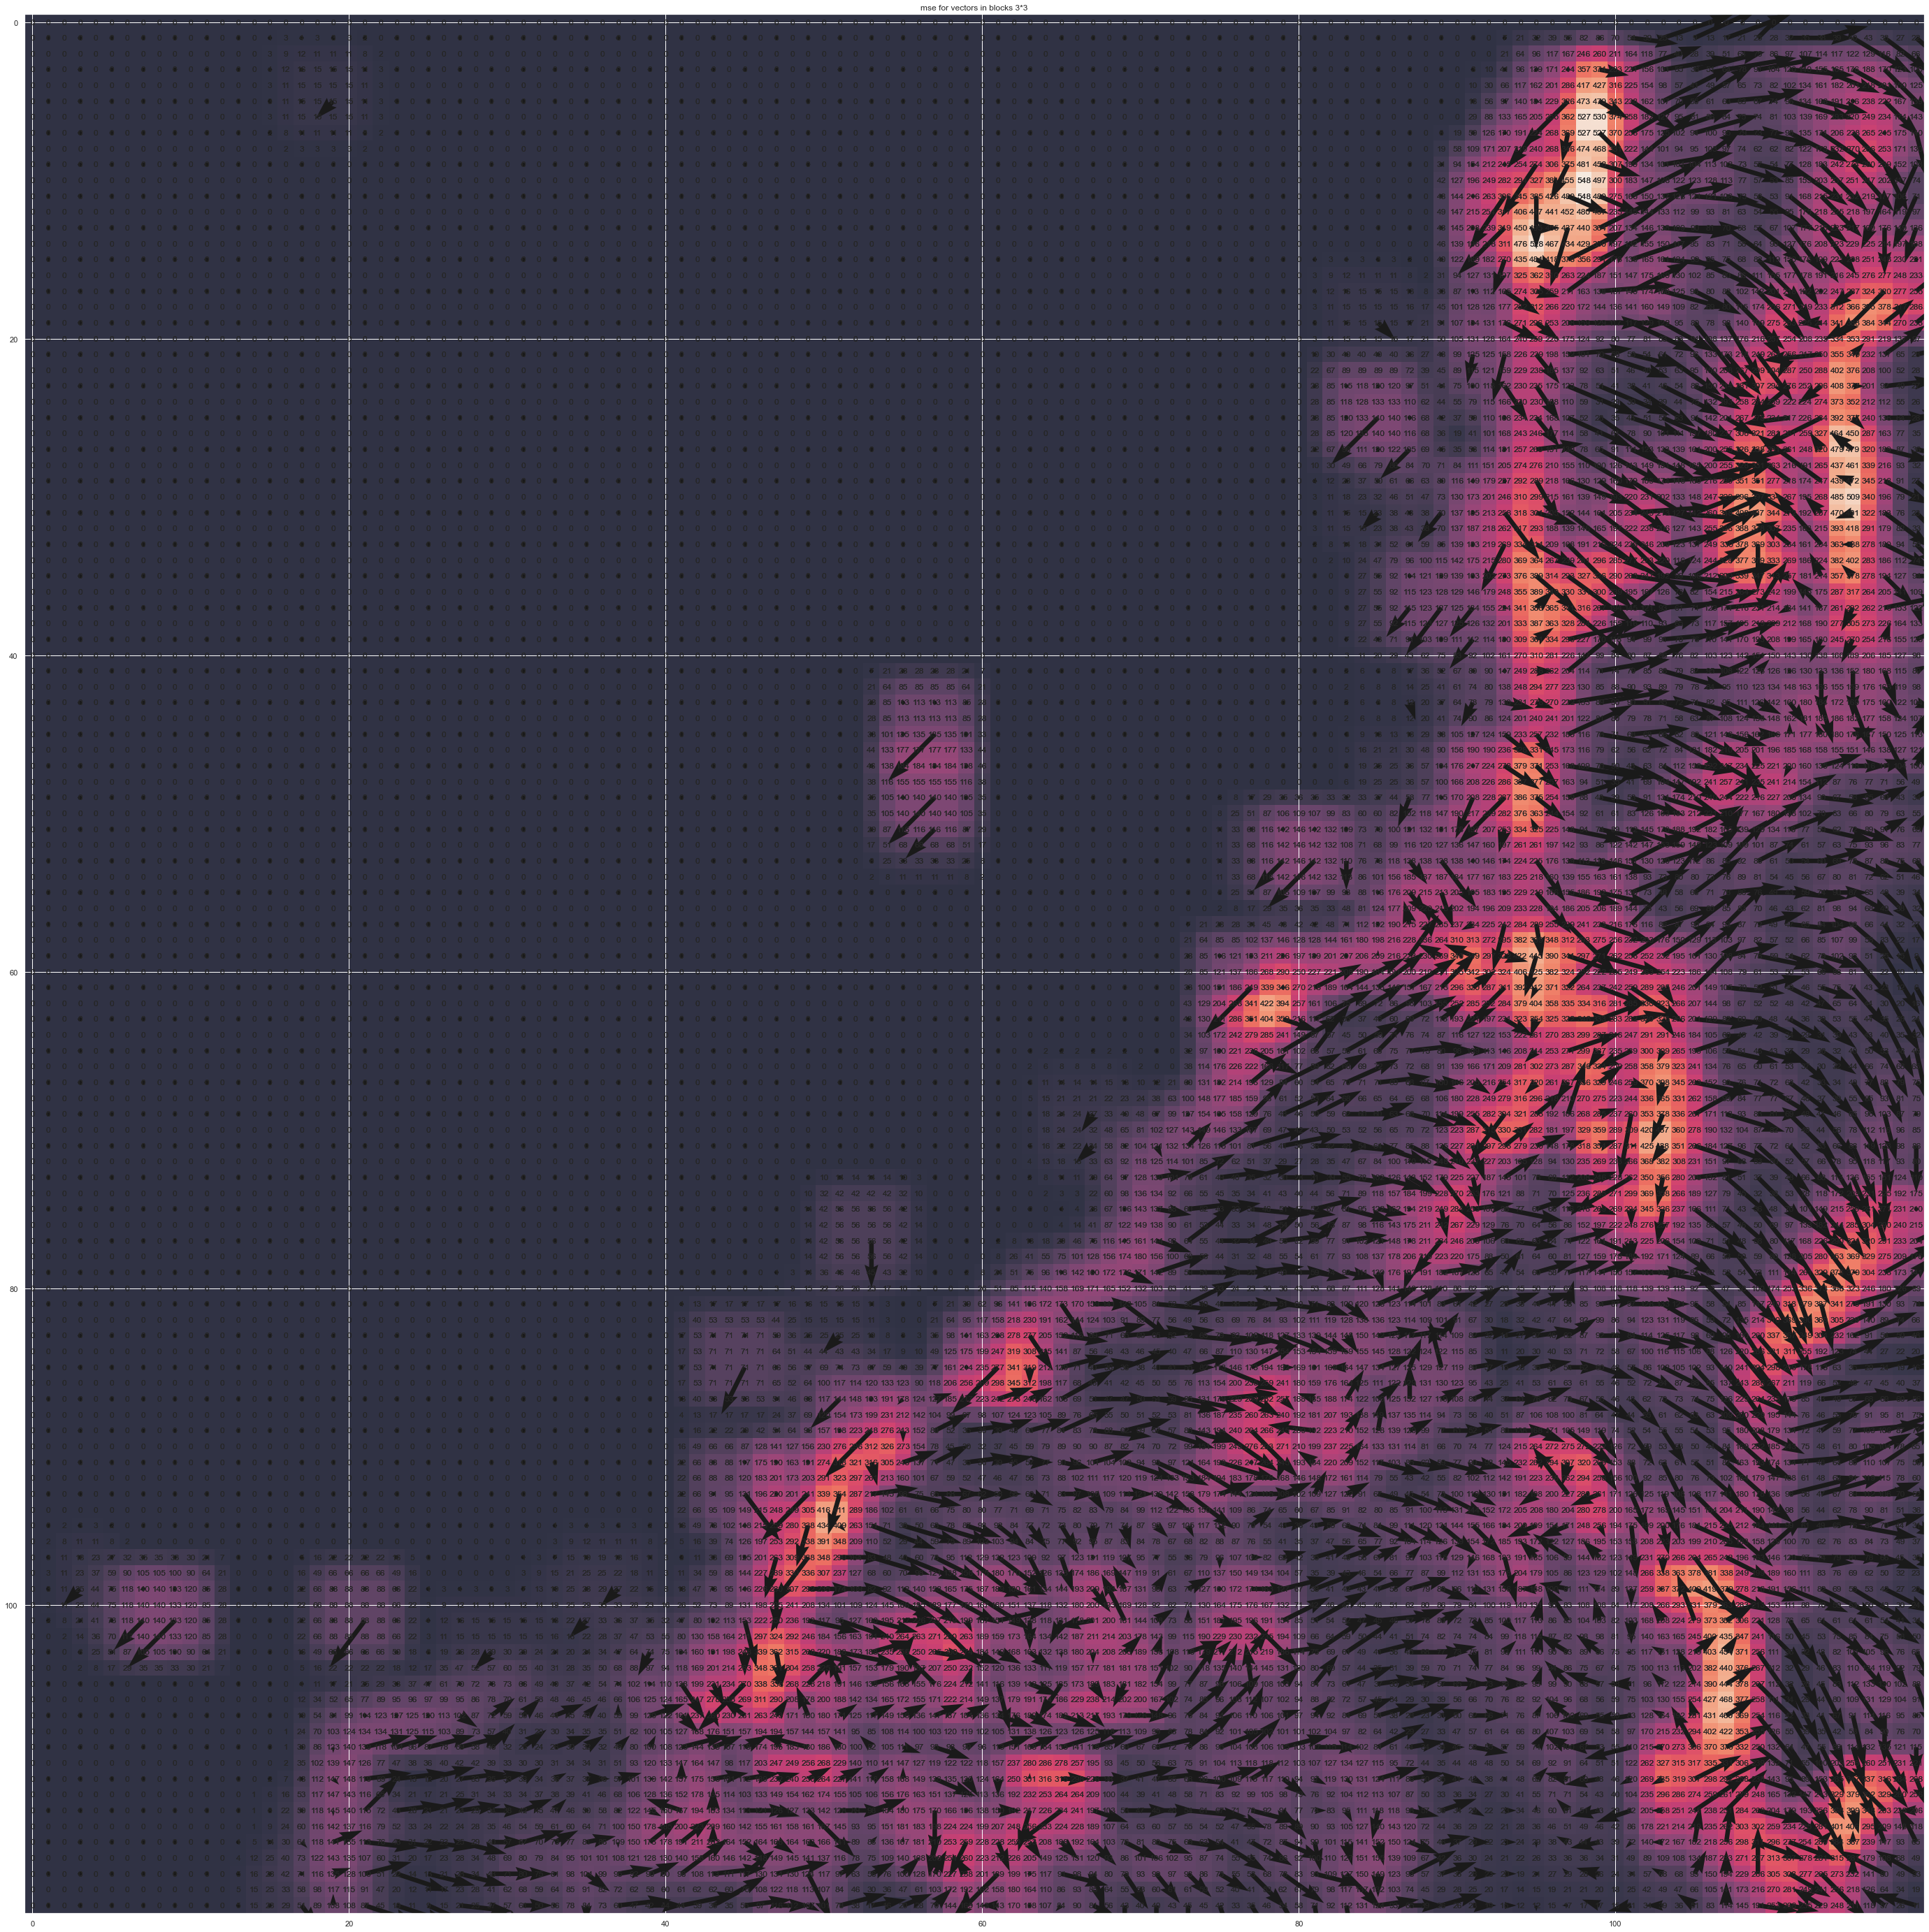

In [97]:
fig = plt.figure(figsize=(50, 50))


def animate(i, block_size = 2):
    plt.clf()
    frame_idx = i + 2
    img = result['source_frames'][frame_idx]
    ofs = result['ofs'][frame_idx]
    
    ver, hor = ofs[0], ofs[1]
    ver = cv2.resize(ver, (ver.shape[1] // block_size, ver.shape[0] // block_size))[30:90, 30:90] #[70:120, 50:100]
    hor = cv2.resize(hor, (hor.shape[1] // block_size, hor.shape[0] // block_size))[30:90, 30:90] #[70:120, 50:100]
#     print(ver.shape)

    def elem(arr, i, j):
        if 0 <= i < arr.shape[0] and 0 <= j < arr.shape[1]:
            return  arr[i][j]
        else:
            return 0

    height, width = ver.shape

    xx, yy = np.meshgrid(np.arange(width), np.arange(height))
    xx = block_size * (xx + 0.5)
    yy = block_size * (yy + 0.5)
    
    
        
    gs = gridspec.GridSpec(2, 2)
#     plt.subplot(gs[:2, :2])
#     plt.title('mv')
#     plt.imshow(img[60:180, 60:180], cmap='gray', alpha=0.5)
#     plt.quiver(xx, yy, hor, ver, angles='xy', scale_units='xy', scale=1)
    
    plt.subplot(gs[:2, 0:2])
    plt.title('mse for vectors in blocks 3*3')
    disp = np.zeros_like(hor)
    for k in range(hor.shape[0]):
        for j in range(hor.shape[1]):
            h = calc_disp(hor[k-1:k+2, j-1:j+2])
            v = calc_disp(ver[k-1:k+2, j-1:j+2])
            d = h + v
            disp[k][j] = d
    disp = cv2.resize(disp, (120, 120)).astype('uint32')

    plt.imshow(disp,  alpha=0.8)
    plt.quiver(xx, yy, hor, ver) #, angles='xy', scale_units='xy', scale=1)
    for (j,i),label in np.ndenumerate(disp):
        plt.text(i,j,label,ha='center',va='center')
        plt.text(i,j,label,ha='center',va='center')

animate(20)
# anim = FuncAnimation(fig, animate)
# name = 'dispersion_of_vectors'
# f = fr"c://Users/1/Desktop/{name}.mp4" 
# writervideo = animation.FFMpegWriter(fps=10) 
# anim.save(f, writer=writervideo)

In [18]:
for i in range(30, 31):
    print(peak_signal_noise_ratio(result['source_frames'][i], result['compensated_frames'][i]))

27.736904596652284


In [19]:
res = result['ofs'][25][0]
res = cv2.resize(res, (res.shape[1] // 8, res.shape[0] // 8))
res = res.flatten()
print(res.min())

-12.75


Примером ниже можно посмотреть графики, как покадрово работает ваш алгоритм. 

In [21]:
import pandas as pd

def test_all_me(video_paths=['source.avi'], qualities=[100, 80, 60, 40, 20], halfpixels=[False, True]):
    result = []
    for video_path in video_paths:
        for halfpixel in halfpixels:
            for quality in qualities:
                video = VideoReader(video_path)
                me = MotionEstimator(video.width, video.height, quality, halfpixel)
                metrics = test_me(video, me)
                result.append(
                    {
                        'video': video_path,
                        'halfpixel': halfpixel,
                        'quality': quality,
                        **{
                            key: np.mean(metrics[key])
                            for key in metrics
                        }
                    }
                )
    return pd.DataFrame(result)

In [22]:
result_all = test_all_me(
    video_paths=['video/source.avi'],
    qualities=[100, 100, 100, 100, 100, 100],# 80, 60, 40, 20],
    halfpixels=[False]#, True]
)

0it [00:00, ?it/s]

c:\users\1\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\1\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<Figure size 864x432 with 0 Axes>

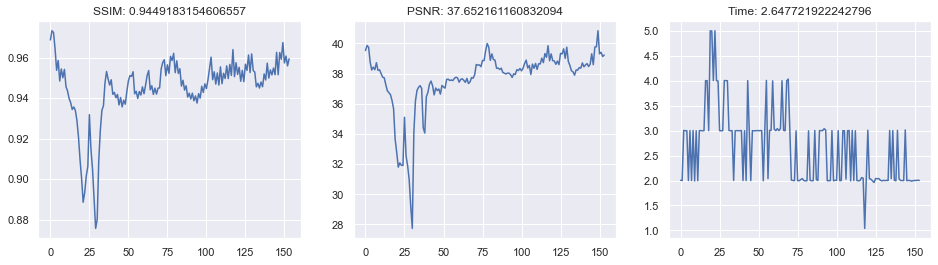

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("notebook")
plt.figure(figsize=(12, 6))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(result['ssim'])
ax1.set_title('SSIM: {}'.format(np.mean(result['ssim'])))
ax2.plot(result['psnr'])
ax2.set_title('PSNR: {}'.format(np.mean(result['psnr'])))
ax3.plot(result['speed'])
ax3.set_title('Time: {}'.format(np.mean(result['speed'])));

In [23]:
result_all

video  halfpixel  quality      ssim       psnr     speed  \
0  video/source.avi      False      100  0.944918  37.652161  3.388586   
1  video/source.avi      False      100  0.944918  37.652161  2.652753   
2  video/source.avi      False      100  0.944918  37.652161  2.702326   
3  video/source.avi      False      100  0.944918  37.652161  2.836969   
4  video/source.avi      False      100  0.944918  37.652161  3.725163   
5  video/source.avi      False      100  0.944918  37.652161  3.067690   

   compensated_frames  source_frames  ofs  
0                 NaN            NaN  NaN  
1                 NaN            NaN  NaN  
2                 NaN            NaN  NaN  
3                 NaN            NaN  NaN  
4                 NaN            NaN  NaN  
5                 NaN            NaN  NaN

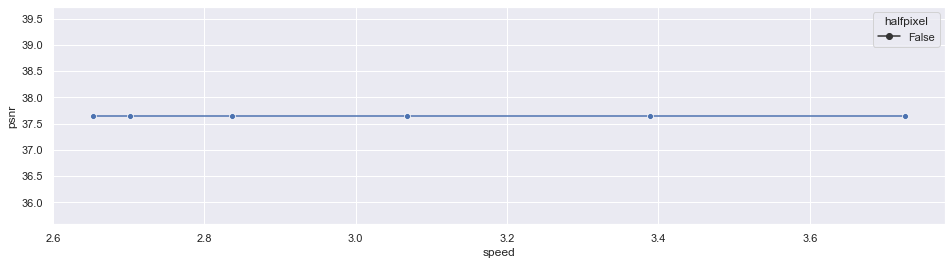

In [24]:
fig, axes = plt.subplots(1, len(result_all['video'].unique()), figsize=(16, 4))
if len(result_all['video'].unique()) == 1:
    axes = [axes]
for ax, video in zip(axes, result_all['video'].unique()):
    sns.lineplot(x='speed', y='psnr', style='halfpixel', markers=True, data=result_all[result_all.video == video], ax=ax)

## 2. Красивый вид кривых скорость/качество ##

*Это бонусное задание, за него вы получите баллы независимо от результатов в конкурсе*

Что хочется увидеть: у ME есть два ключевых параметра, определяющих его "хорошесть" - это скорость работы и качество сопоставления. Очевидно, можно написать метод, который делает полный перебор - он будет лучшим по качеству, но медленным, или наоборот - ничего не сопоставляем: ужасное качество, но замечательная скорость, Хочется, чтобы ваш алгоритм позволял варьировать скорость и качество и не уходил в такие крайности. Ниже пример кривых, которые были в прошлом году - хочется, чтобы форма кривых была как можно ближе к синей c треугольниками:

<img src="images/curves.png">

## 3. Опиши что было сделано ##

*Это тоже небольшое бонусное задание*  
Пожалуйста, опиши (кратко) суть твоего алгоритма, какие алгоритмы за основу ты взял и что решил улучшить.  
Также было бы неплохо, если ты приложишь графики, которые показывают, как каждое улучшение срабатывало.  
Если хочешь, можешь здесь вести небольшой дневник - какие эксперименты ты проводил, какие у тебя были гипотезы и какие у тебя получались результаты

### Что за алгоритм?
Я пытался наиграть на скорости используя 4 основные идеи: 
* усреднение
* использование векторов, полученных для предыдущего кадра  
* умный перебор
* исопльзование блоков маленького размера

Расскажу про каждую поподробнее
### Усреднение
Идея, которая пришла мне в один из первых дней после выдачи задания. 
Раскрасим блоки шахматной раскраской. Блоки одного цвета будем считать качественно. Блоки другого цвета будем навскидку: посмотрим на вектора, посчитанные для блоков слева, сверху, справа и снизу. Так как мы раскрасили блоки шахматной раскраской, то для этих блоков вектора будут посчитаны. Ну и усредним значение. А затем уточним полученный вектор.
Такая техника снижала скорость в полтора-два раза, а качество на 1-1.5 децибелла - довольно круто.
Вот визуализация векторов:
<img src="images/Screenshot_165.png">
### Векторы с предыдущего кадра
Смысл в том, что мы можем понять, что происходит в области, просто посмотрев на вектора подсчитанные ранее, для предыдущего кадра. Конечно, это не 100% оценка, поскольку за один кадр все может сильно измениться, но пользу это дает. Это можно использовать, чтобы определиться с точностью поиска и начальным приближением. Если вектора соноправлены, мы можем считать что в рассматриваемом месте находится движущаяся область.
### Умный перебор
Тут я очень много наиграл. Что использовалось?
1. Сначала работаем полным перебором, но с большим шагом. Находим начальное приближение. Потом уточняем начальное приближение полным перебором в маленькой области, но с крупным шагом.
2. Считаем, только если точность плохая - экономим на фоне и лице
Вот графики, которые демонстируют как выглядят mse и psnr до и после работы алгоритмы (для полного перебора графики выгядят очень похоже). Числа обозначают удельные значения mse / psnr.

0.0 1.72 7.3125
0.1875 1.79875 7.5


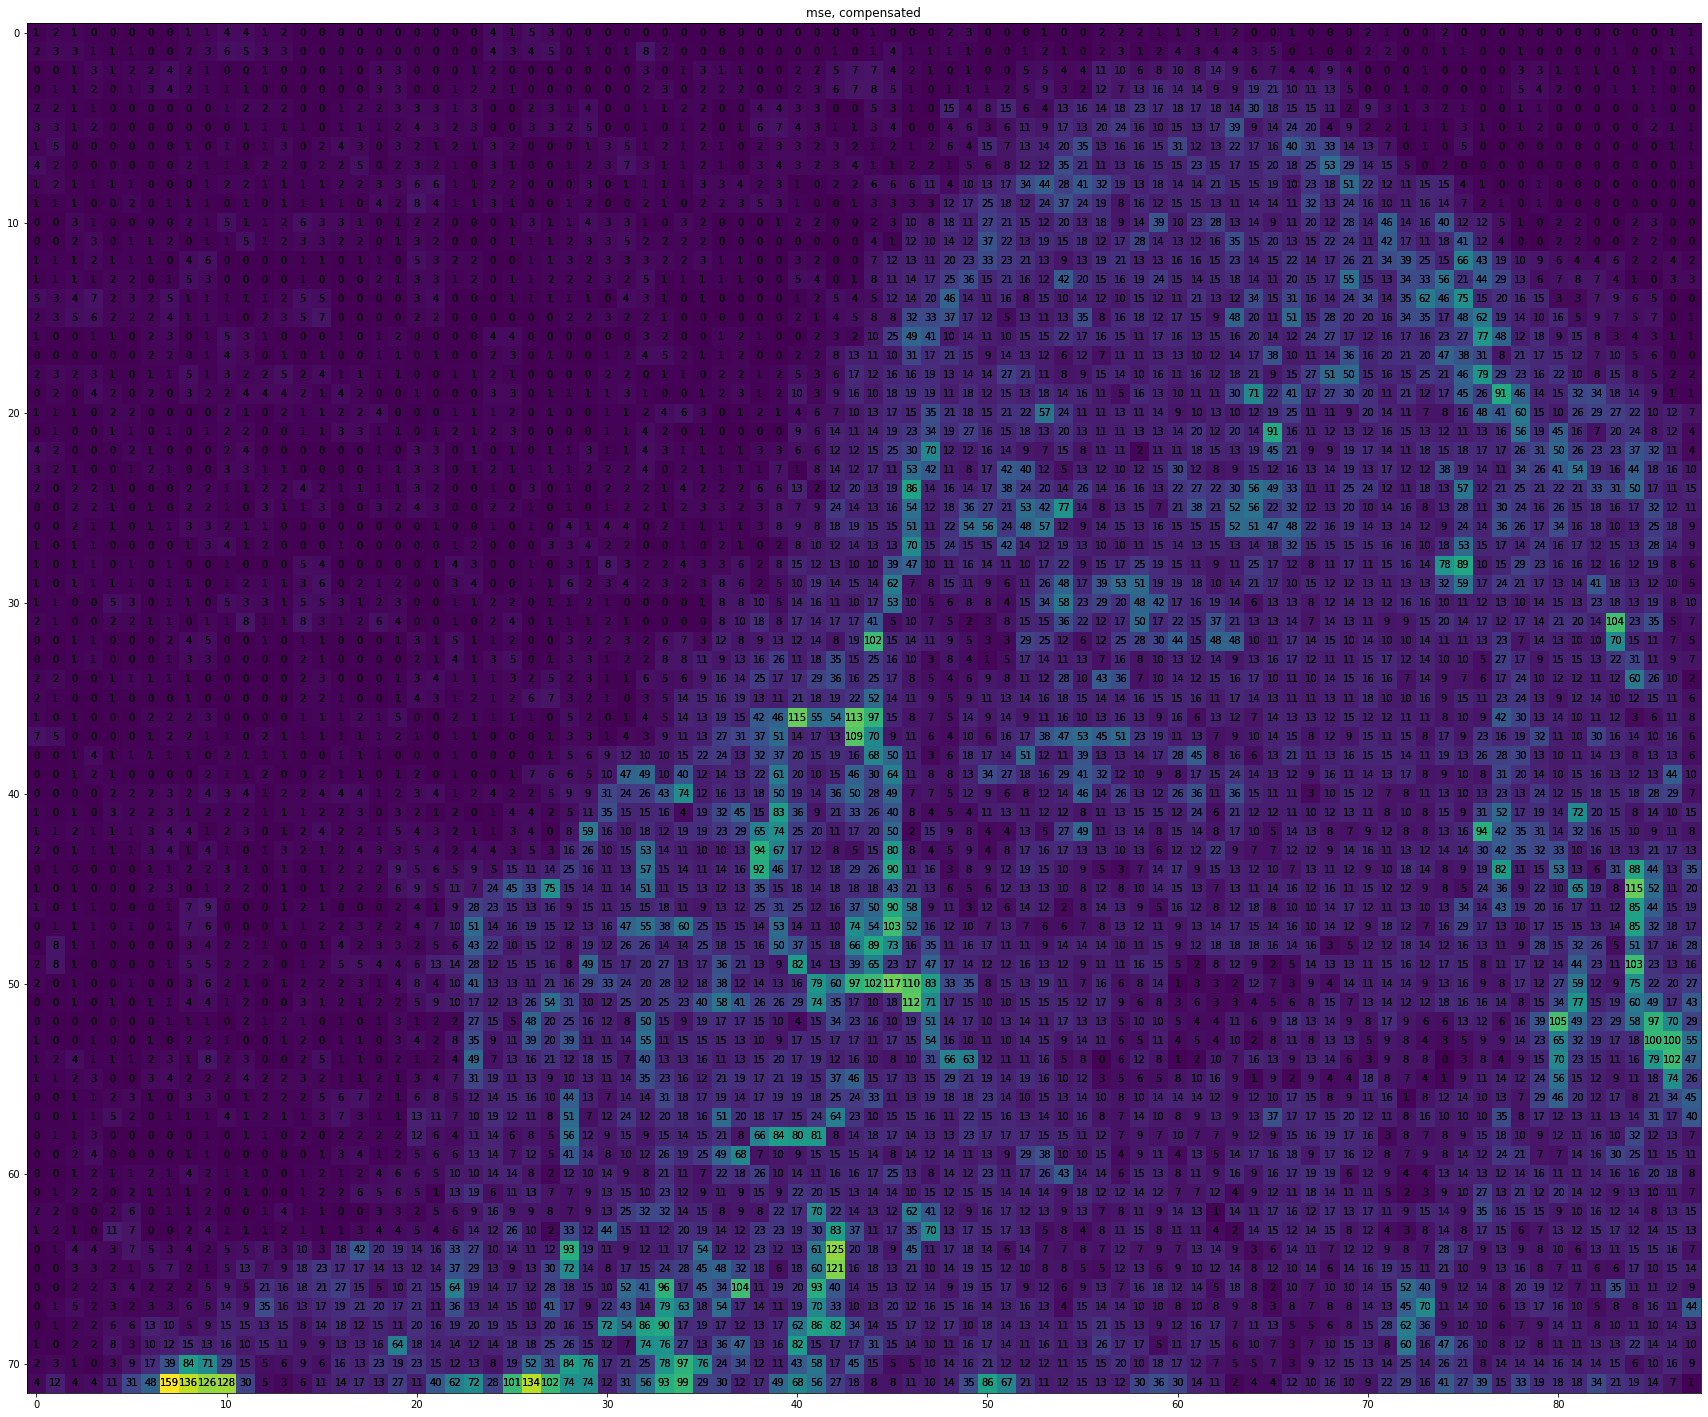

In [13]:
fig = plt.figure(figsize=(30, 30))
frame_idx = 25
plt.title('mse, compensated')
errors = calc_mse_for_blocks(result['source_frames'][frame_idx], result['compensated_frames'][frame_idx], block_size = 4)
plt.imshow(errors, vmin = 0, vmax = 150)

for (j,i),label in np.ndenumerate(errors.astype('uint8')):
    plt.text(i,j,label,ha='center',va='center')
    plt.text(i,j,label,ha='center',va='center')
    
print(errors[0:20, 0:10].min(), errors[0:20, 0:10].mean(), errors[0:20, 0:10].max())
print(errors[5:10, 25:35].min(), errors[5:10, 25:35].mean(), errors[5:10, 25:35].max())

0.0 1.72 7.3125
0.1875 1.79875 7.5


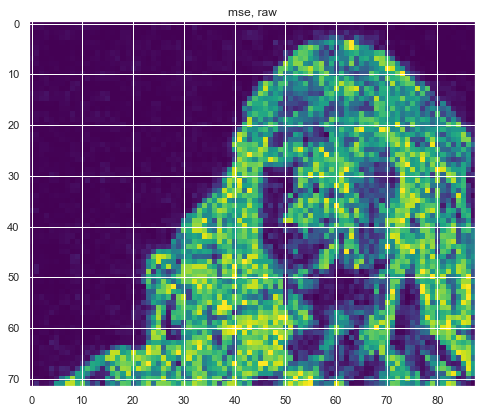

In [117]:
fig = plt.figure(figsize=(8, 8))
frame_idx = 25
plt.title('mse, raw')
errors = calc_mse_for_blocks(result['source_frames'][frame_idx], result['source_frames'][frame_idx + 1], block_size = 4)
plt.imshow(errors, vmin = 0, vmax = 150, cmap = 'viridis')

# for (j,i),label in np.ndenumerate(errors.astype('uint8')):
#     plt.text(i,j,label,ha='center',va='center')
#     plt.text(i,j,label,ha='center',va='center')
    
print(errors[0:20, 0:10].min(), errors[0:20, 0:10].mean(), errors[0:20, 0:10].max())
print(errors[5:10, 25:35].min(), errors[5:10, 25:35].mean(), errors[5:10, 25:35].max())

39.49014481777673 inf inf
39.3801909747621 47.10049064777136 55.400790888041726


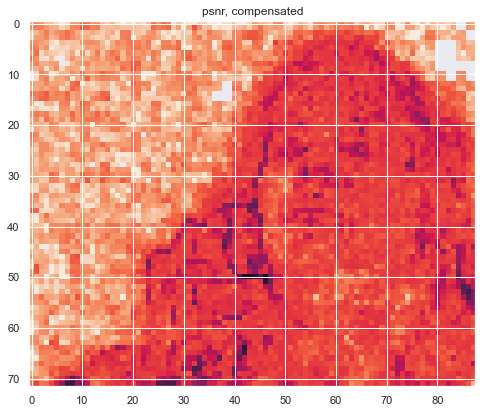

In [118]:
fig = plt.figure(figsize=(8, 8))
frame_idx = 25
plt.title('psnr, compensated')
errors = calc_psnr_for_blocks(result['source_frames'][frame_idx], result['compensated_frames'][frame_idx], block_size = 4)
plt.imshow(errors, vmin = 10, vmax = 55)

# for (j,i),label in np.ndenumerate(errors.astype('uint8')):
#     plt.text(i,j,label,ha='center',va='center')
#     plt.text(i,j,label,ha='center',va='center')
    
print(errors[0:20, 0:10].min(), errors[0:20, 0:10].mean(), errors[0:20, 0:10].max())
print(errors[5:10, 25:35].min(), errors[5:10, 25:35].mean(), errors[5:10, 25:35].max())

39.49014481777673 inf inf
39.3801909747621 47.10049064777136 55.400790888041726


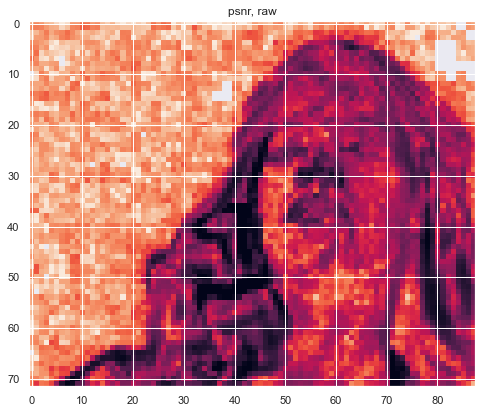

In [119]:
fig = plt.figure(figsize=(8, 8))
frame_idx = 25
plt.title('psnr, raw')
errors = calc_psnr_for_blocks(result['source_frames'][frame_idx], result['source_frames'][frame_idx + 1], block_size = 4)
plt.imshow(errors, vmin = 10, vmax = 55)

# for (j,i),label in np.ndenumerate(errors.astype('uint8')):
#     plt.text(i,j,label,ha='center',va='center')
#     plt.text(i,j,label,ha='center',va='center')
    
print(errors[0:20, 0:10].min(), errors[0:20, 0:10].mean(), errors[0:20, 0:10].max())
print(errors[5:10, 25:35].min(), errors[5:10, 25:35].mean(), errors[5:10, 25:35].max())

Вот статистика ошибкок: 
* на фоне
* на волосах
* на изображении

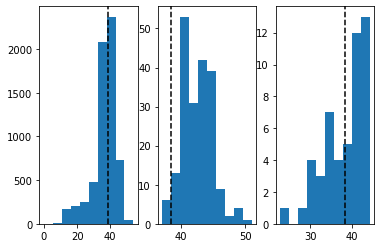

In [17]:
frame_idx = 30

plt.subplot(1, 3, 1)
res = psnr_for_blocks(frame_idx, 4).astype('uint8').flatten()
plt.hist(res, bins = 10)
plt.axvline(x = peak_signal_noise_ratio(result['source_frames'][i], result['compensated_frames'][i]), 
            color="black", linestyle="--")

plt.subplot(1, 3, 2)
res = psnr_for_blocks(frame_idx, 4)[0:20, 0:10].astype('uint8').flatten()
plt.hist(res, bins = 10)
plt.axvline(x = peak_signal_noise_ratio(result['source_frames'][i], result['compensated_frames'][i]), 
            color="black", linestyle="--")

plt.subplot(1, 3, 3)
res = psnr_for_blocks(frame_idx, 8)[5:10, 25:35].flatten()
plt.hist(res, bins = 10)
plt.axvline(x=np.average(res), color="black", linestyle="--")


plt.show()

Видно две вещи:
1. Фон не улучшается - значит можно его не считать
2. Края картинки не улучаются - и бог с ними
### Дисперсия векторов
Идея, о которой говорилось ранее. Смотрим, как сильно вектора отличаются. Если сильно - не берем начальное приближение с предыдущего кадра. Ниже график, иллюстрирующий диспресию, рассчитанную для блоков 3x3. Если приглядеться видны чиса - значения.

<ipython-input-96-406b23fa09e7>:2: RuntimeWarning: Mean of empty slice.
  return ((hor - hor.mean()) ** 2).sum()


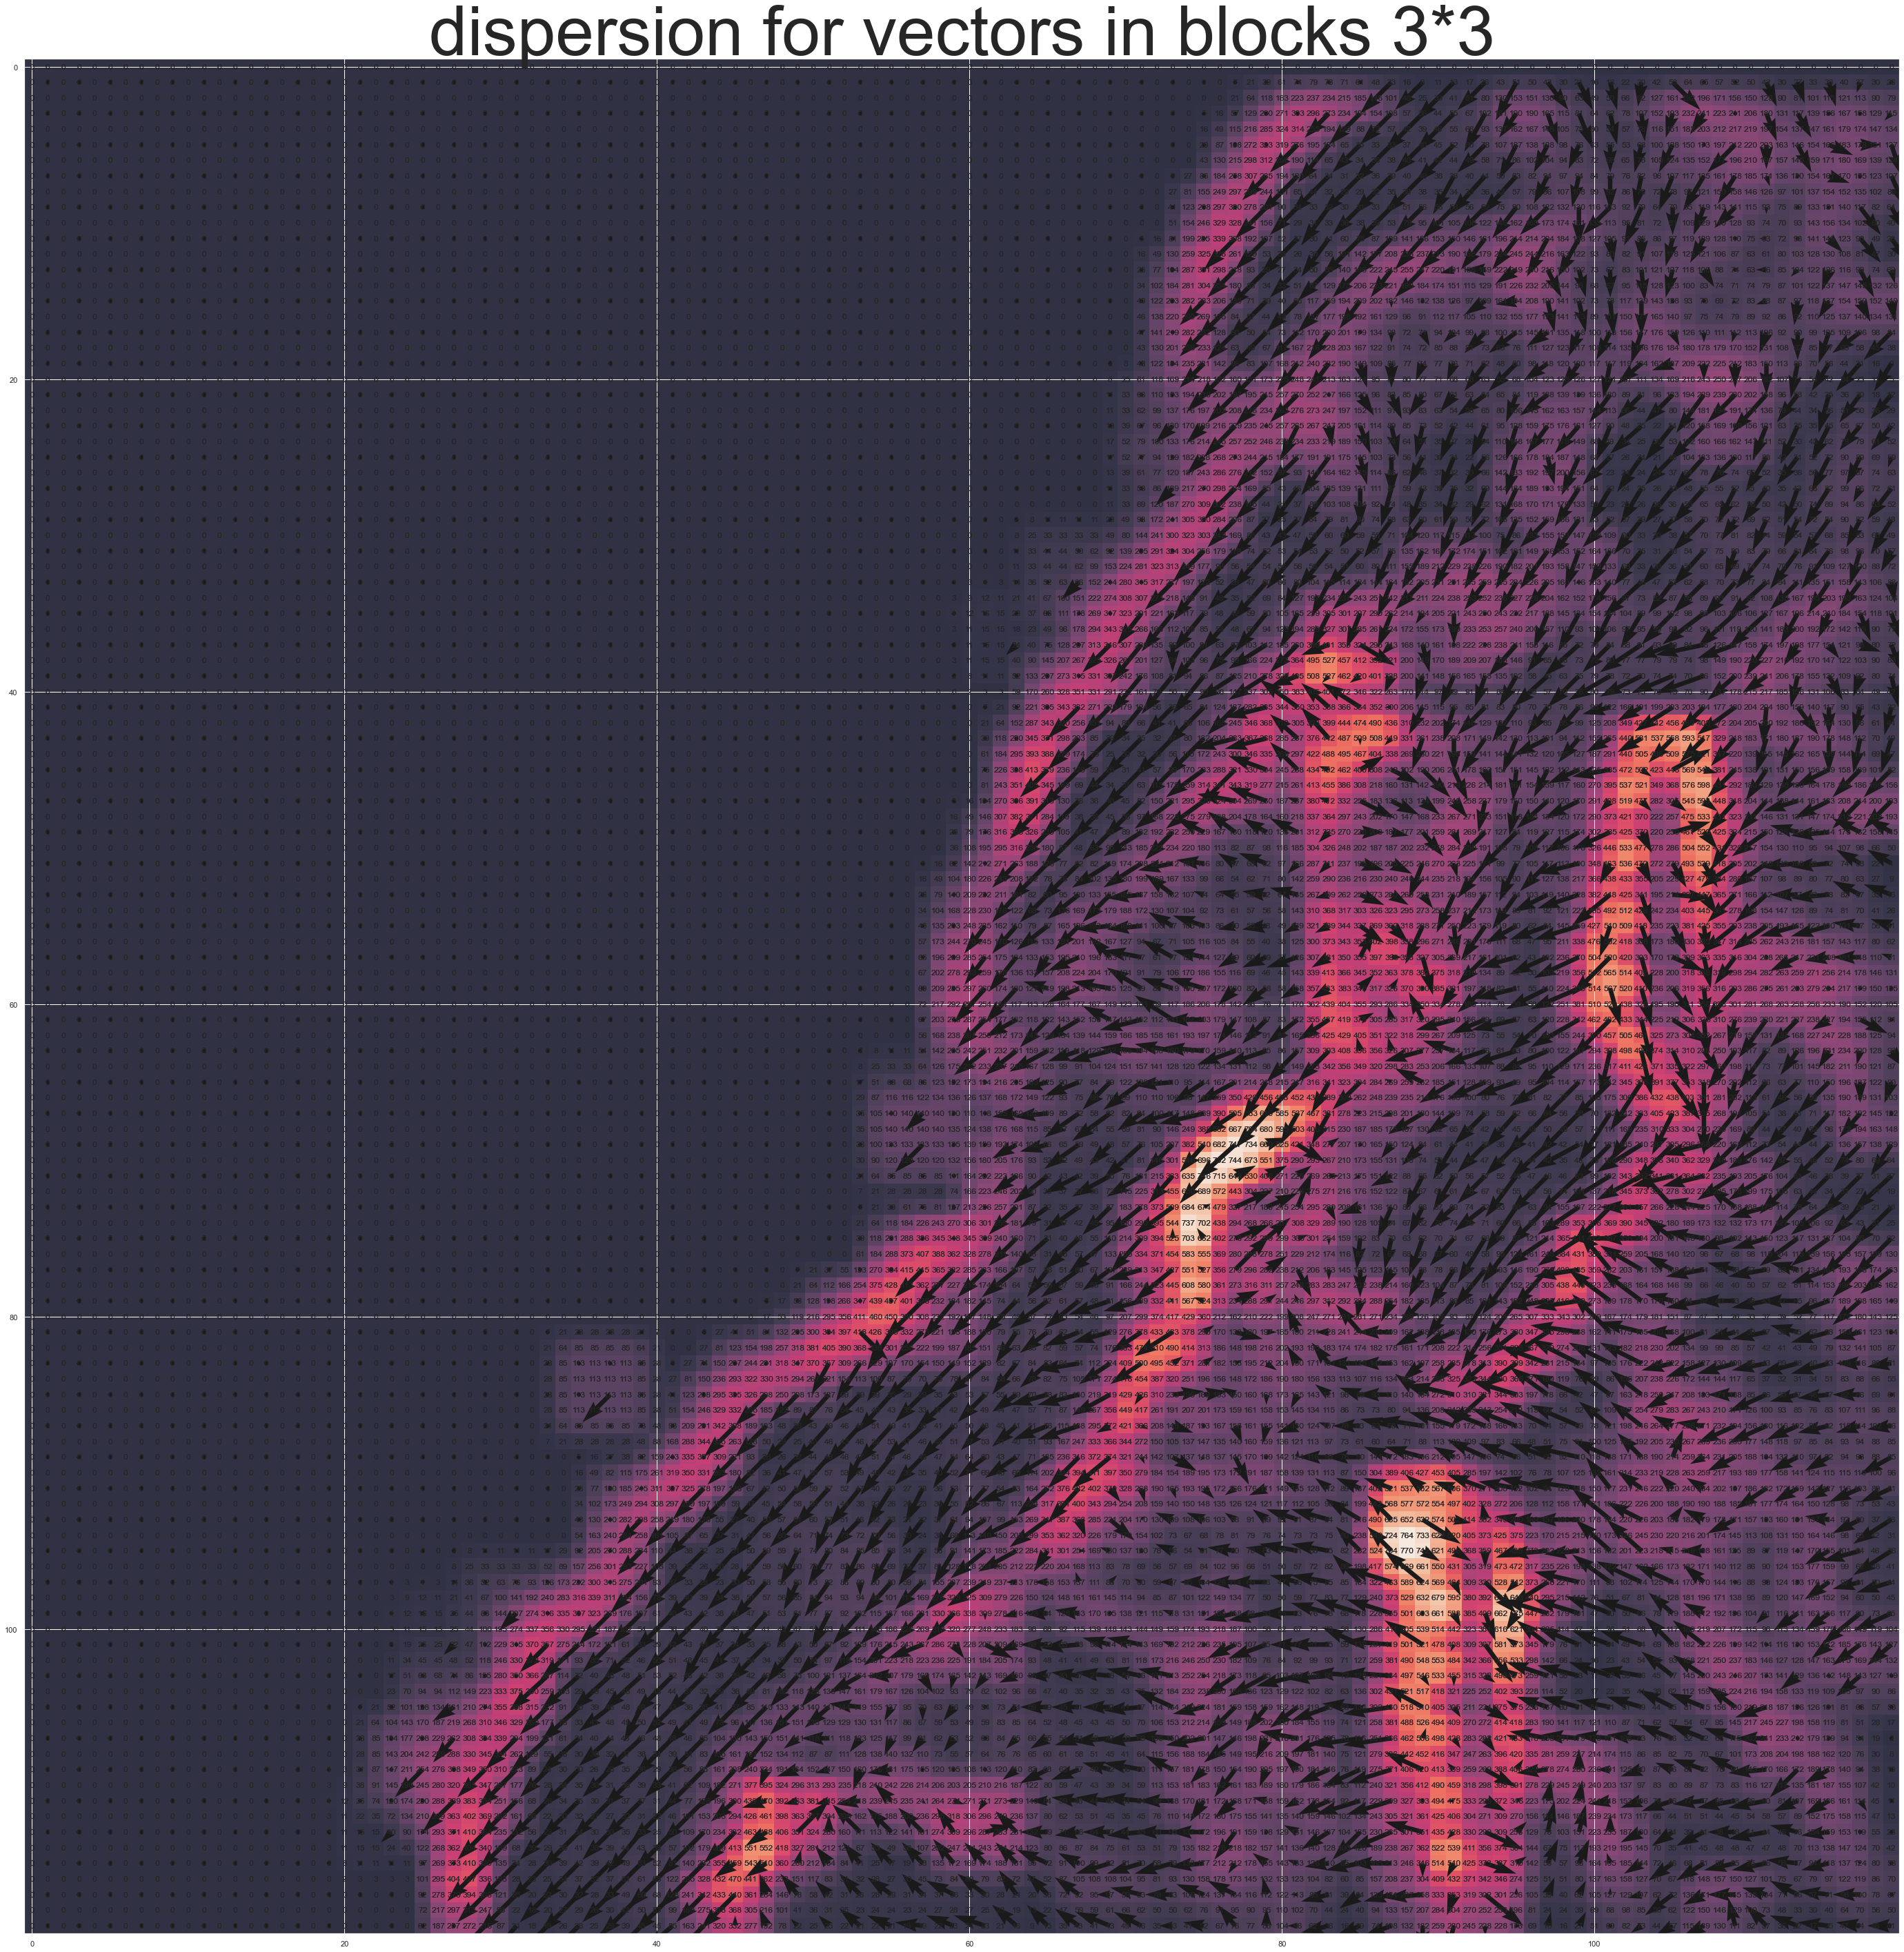

In [111]:
plt.figure(figsize = (50, 50))
frame_idx = 27
img = result['source_frames'][frame_idx]
ofs = result['ofs'][frame_idx]
block_size = 2

ver, hor = ofs[0], ofs[1]
ver = cv2.resize(ver, (ver.shape[1] // block_size, ver.shape[0] // block_size))[30:90, 30:90] #[70:120, 50:100]
hor = cv2.resize(hor, (hor.shape[1] // block_size, hor.shape[0] // block_size))[30:90, 30:90] #[70:120, 50:100]

def elem(arr, i, j):
    if 0 <= i < arr.shape[0] and 0 <= j < arr.shape[1]:
        return  arr[i][j]
    else:
        return 0

height, width = ver.shape

xx, yy = np.meshgrid(np.arange(width), np.arange(height))
xx = block_size * (xx + 0.5)
yy = block_size * (yy + 0.5)

gs = gridspec.GridSpec(2, 2)

plt.subplot(gs[:2, 0:2])
plt.title('dispersion for vectors in blocks 3*3', size = 100)
disp = np.zeros_like(hor)
for k in range(hor.shape[0]):
    for j in range(hor.shape[1]):
        h = calc_disp(hor[k-1:k+2, j-1:j+2])
        v = calc_disp(ver[k-1:k+2, j-1:j+2])
        d = h + v
        disp[k][j] = d
disp = cv2.resize(disp, (120, 120)).astype('uint32')

plt.imshow(disp,  alpha=0.8)
plt.quiver(xx, yy, hor, ver) #, angles='xy', scale_units='xy', scale=1)
for (j,i),label in np.ndenumerate(disp):
    plt.text(i,j,label,ha='center',va='center')
    plt.text(i,j,label,ha='center',va='center')
plt.show()

Еще один интересный график, визуализирущий изображение, вектора и величину ошибки:
<img src="images/Screenshot_162.png">

### Использование блоков маленького размера
Идея, которая дала максимум пользы. Я подумал: как у первого места в прошлом году результат psnr = 37, когда блоки 16х16 дает максимум 35.5, а 8х8 - 36.6? Так я перешел сначала на блоки 4х4, а потом 2х2. Ради интереса я пробовал блоки 1х1 - optical flow - результаты поразили. С моими оптимизациями давало 41 psnr за 10 миллисекунд - страшное дело.

### Тестирование
Для ускорения времени тестрования я придумал скрипт, который комплирует программу, запускает ее, записывает результаты в акккуратном формате в специальный файл и добавляет комментарий, который я могу задать аргументом скрипта. Вот код:

Также было проведено около ~150 тестов и построено 30 анимаций.
### Найденный ошибки:
1. Видео тестируется задом-наперед
2. Анимация векторов неправлиьная: функция plt.quiver нормализует вектора

## 4. Немного подсказок

* Напишите сначала какой-нибудь базовый алгоритм, который будет вашим бейзлайном. Затем вы будете его постепенно улучшать
* После этого тестируйте каждое улучшение (одно улучшние - один эксперимент), чтобы не добавить в алгоритм то, что на самом деле ухушает алгоритм
* Не стесняйтесь проводить всякие эксперименты вне кода. Например, можно самостоятельно построить пример рельефа ошибки при сопоставлении, смотреть, насколько близки вектора у соседних блоков, исследовать стабильность векторов блоков по времени. Это позволит каждому улучшению работать максимально эффективно.

## 5. Что такое halfpixel

Пусть нам дан кадр размера 3x2 и мы нашли вектор движения на целочисленной сетке (на рисунке cерая). Чтобы уточнить результат, можно перейти к полупиксельной точности. Интерполируем значения пикселей в нецелых координатах (белых).

<img src="images/halfpixel1.png">
Чтобы избежать работы с в нецелых координатах, будем представлять изображение в два раза большим, а все координаты целыми. Теперь найдем вектор сдвига на полученной сетке. Разделив его на два по каждой координате, мы перейдем назад к неинтерполированным координатам.

В шаблоне уже реализована функция `generate_subpixel_arrays`. По входному кадру она генерирует выходной интерполированный. Интерполированный кадр хранится особым образом: это четыре массива `original`, `left`, `upper`, `upper left`, содержащие соответсвующие интерполированные пиксели. На рисунке изображен пример для кадра размера 3x2.

<img src="images/halfpixel2.png">

Все кадры хранятся в виде одномерного массива. Доступ к конкретному пикселю осуществляется по формуле `y * width + x`. Кроме того для удобства каждый кадр окружен рамками — не придется заботиться о граничных условиях, но поменяется формула досутпа к пикселю. Все необходимые для этого смещения уже реализованы в бейзлайне.